In [1]:
import torch
from torch import nn
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, CenterCrop, Grayscale
import matplotlib.pyplot as plt
import time
import dataset as data
import model as md
import numpy as np

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using {} device".format(DEVICE))

Using cpu device


In [2]:
## Hyperparameters
Batch_size = 2
Optimizer_type = 'ADAM'
Learning_rate = 1e-5
Weight_decay = 0
epochs = 15

In [3]:
def Sample_visualize(dataloader) :
  ## Visualize some preprocess images
  ##
  ## Input : dataloader of image dataset
  ## Output : image plots

 dataiter = iter(dataloader)
 images, labels = next(dataiter)
 # images = images.numpy()
 for i in range (2) :
   plt.subplot(1,4,i+1)
   plt.imshow(images[i].reshape((64, 192)), cmap='gray')
   plt.xticks([])
   plt.yticks([])
   print(images.size())
   print(labels)

def visualize_dataset(dataset):
  ## Visualize some preprocess images
  ##
  ## Input : DATASET of image dataset
  ## Output : image plots
  images, labels = dataset[0]
  print(images.size())
  images = images.numpy()
  plt.imshow(images.reshape((64, 192)), cmap='gray')
  plt.xticks([])
  plt.yticks([])
  print(labels)

In [4]:
# train_dataset = data.LicensePlateDataset(directory='./CNN_generated_dataset', label_file='./CNN_generated_dataset/Labels.csv')
# train_loader = DataLoader(train_dataset, batch_size=Batch_size, shuffle=True)

# val_dataset = data.LicensePlateDataset(directory='./CNN_generated_dataset_val', label_file='./CNN_generated_dataset_val/Labels.csv')
# val_loader = DataLoader(val_dataset, batch_size=Batch_size, shuffle=True)
#
# test_dataset = data.LicensePlateDataset(directory='./CNN_generated_dataset_test', label_file='./CNN_generated_dataset_test/Labels.csv')
# test_loader = DataLoader(test_dataset, batch_size=Batch_size, shuffle=True)

from torch.utils.data import DataLoader, random_split

full_dataset = data.LicensePlateDataset(resize_size=(64, 192),directory='./CNN_generated_dataset', label_file='./CNN_generated_dataset/Labels.csv')
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=Batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=Batch_size, shuffle=True)


torch.Size([2, 1, 64, 192])
tensor([[ 4, 11, 33, 15, 24,  5, 29, 15,  3, 21,  3],
        [26, 11, 30, 29, 28, 24,  2, 15, 29, 32,  6]])
torch.Size([2, 1, 64, 192])
tensor([[ 4, 11, 33, 15, 24,  5, 29, 15,  3, 21,  3],
        [26, 11, 30, 29, 28, 24,  2, 15, 29, 32,  6]])


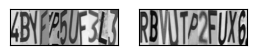

In [5]:
# visualize_dataset(full_dataset)
Sample_visualize(train_loader)

In [6]:
model = md.CNN(init_weights=True)
model.to(DEVICE)
print(model)

CNN(
  (localization): Sequential(
    (0): Conv2d(1, 48, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(48, 32, kernel_size=(5, 5), stride=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=18720, out_features=100, bias=True)
    (10): ReLU()
    (11): Linear(in_features=100, out_features=6, bias=True)
    (12): ReLU()
  )
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

In [7]:
import torchsummary

torchsummary.summary(model,input_size=(1,64,192))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 64, 60, 188]           1,664
       BatchNorm2d-2          [-1, 64, 60, 188]             128
              ReLU-3          [-1, 64, 60, 188]               0
         MaxPool2d-4           [-1, 64, 30, 94]               0
           Dropout-5           [-1, 64, 30, 94]               0
            Conv2d-6          [-1, 128, 28, 92]          73,856
       BatchNorm2d-7          [-1, 128, 28, 92]             256
              ReLU-8          [-1, 128, 28, 92]               0
         MaxPool2d-9          [-1, 128, 14, 46]               0
          Dropout-10          [-1, 128, 14, 46]               0
           Conv2d-11          [-1, 256, 12, 44]         295,168
      BatchNorm2d-12          [-1, 256, 12, 44]             512
             ReLU-13          [-1, 256, 12, 44]               0
        MaxPool2d-14           [-1, 256

In [8]:
# from torchviz import make_dot
# from torch.autograd import Variable
#
# x = Variable(torch.randn(1, 1, 64, 192))
#
# make_dot(model(x), params=dict(model.named_parameters())).render("graph", format="png")

In [9]:
loss_fn = nn.CrossEntropyLoss().to(DEVICE)

if Optimizer_type == 'ADAM' :
  optimizer = torch.optim.Adam(model.parameters(), lr = Learning_rate, weight_decay = Weight_decay)
elif Optimizer_type == 'SGD' :
  optimizer = torch.optim.SGD(model.parameters(), lr = Learning_rate, weight_decay = Weight_decay)

In [10]:
# ## Training function ##
# def train(dataloader, model, loss_fn, optimizer):
#   model.train()
#   for batch_idx, (X,y) in enumerate(dataloader):

#     X = X.to(DEVICE)
#     pred0, pred1, pred2, pred3, pred4, pred5, pred6, pred7, pred8, pred9, pred10 = model(X)
#     # loss = 0.
#     # for idx in range(11):
#     #   y[idx] = y[idx].to(DEVICE)
#     #   loss += loss_fn(torch.tensor(pred[idx], dtype=torch.float32), y[idx])
#     for idx in range(11):
#       y[idx] = y[idx].to(DEVICE)

#     loss0 = loss_fn(pred0, y[0])
#     loss1 = loss_fn(pred1, y[1])
#     loss2 = loss_fn(pred2, y[2])
#     loss3 = loss_fn(pred3, y[3])
#     loss4 = loss_fn(pred4, y[4])
#     loss5 = loss_fn(pred5, y[5])
#     loss6 = loss_fn(pred6, y[6])
#     loss7 = loss_fn(pred7, y[7])
#     loss8 = loss_fn(pred8, y[8])
#     loss9 = loss_fn(pred9, y[9])
#     loss10 = loss_fn(pred10, y[10])
#     loss = loss0 + loss1 + loss2 + loss3 + loss4 + loss5 + loss6 + loss7 + loss8 + loss9 + loss10

#     optimizer.zero_grad()
#     loss.requires_grad_(True)
#     loss.backward()
#     optimizer.step()

#     if batch_idx % 5 == 0:
#       print('loss: {:.6f} [{}/{}]'.format(loss.item(), batch_idx*len(X), len(dataloader.dataset)))

In [11]:
# ## Validation function ##
# def validation(model, valdata):
#   ## Input : trained model, validation data
#   ## Output : validation loss

#   model.eval()
#   val_loss = 0
#   char_correct = 0
#   plate_correct = 0
#   with torch.no_grad():
#     for X, y in valdata:
#       X = X.to(DEVICE)
#       for idx in range(11):
#         y[idx] = y[idx].to(DEVICE)
#       val_pred0, val_pred1, val_pred2, val_pred3, val_pred4, val_pred5, val_pred6, val_pred7, val_pred8, val_pred9, val_pred10 = model(X)

#       val_loss0 = loss_fn(val_pred0, y[0])
#       val_loss1 = loss_fn(val_pred1, y[1])
#       val_loss2 = loss_fn(val_pred2, y[2])
#       val_loss3 = loss_fn(val_pred3, y[3])
#       val_loss4 = loss_fn(val_pred4, y[4])
#       val_loss5 = loss_fn(val_pred5, y[5])
#       val_loss6 = loss_fn(val_pred6, y[6])
#       val_loss7 = loss_fn(val_pred7, y[7])
#       val_loss8 = loss_fn(val_pred8, y[8])
#       val_loss9 = loss_fn(val_pred9, y[9])
#       val_loss10 = loss_fn(val_pred10, y[10])

#       val_loss += val_loss0 + val_loss1 + val_loss2 + val_loss3 + val_loss4 + val_loss5 + val_loss6 + val_loss7 + val_loss8 + val_loss9 + val_loss10

#       val_pred0 = val_pred0.argmax(dim=-1, keepdim=True)
#       val_pred1 = val_pred1.argmax(dim=-1, keepdim=True)
#       val_pred2 = val_pred2.argmax(dim=-1, keepdim=True)
#       val_pred3 = val_pred3.argmax(dim=-1, keepdim=True)
#       val_pred4 = val_pred4.argmax(dim=-1, keepdim=True)
#       val_pred5 = val_pred5.argmax(dim=-1, keepdim=True)
#       val_pred6 = val_pred6.argmax(dim=-1, keepdim=True)
#       val_pred7 = val_pred7.argmax(dim=-1, keepdim=True)
#       val_pred8 = val_pred8.argmax(dim=-1, keepdim=True)
#       val_pred9 = val_pred9.argmax(dim=-1, keepdim=True)
#       val_pred10 = val_pred10.argmax(dim=-1, keepdim=True)

#       char_correct += val_pred0.eq(y[0].view_as(val_pred0)).sum().item()
#       char_correct += val_pred1.eq(y[1].view_as(val_pred1)).sum().item()
#       char_correct += val_pred2.eq(y[2].view_as(val_pred2)).sum().item()
#       char_correct += val_pred3.eq(y[3].view_as(val_pred3)).sum().item()
#       char_correct += val_pred4.eq(y[4].view_as(val_pred4)).sum().item()
#       char_correct += val_pred5.eq(y[5].view_as(val_pred5)).sum().item()
#       char_correct += val_pred6.eq(y[6].view_as(val_pred6)).sum().item()
#       char_correct += val_pred7.eq(y[7].view_as(val_pred7)).sum().item()
#       char_correct += val_pred8.eq(y[8].view_as(val_pred8)).sum().item()
#       char_correct += val_pred9.eq(y[9].view_as(val_pred9)).sum().item()
#       char_correct += val_pred10.eq(y[10].view_as(val_pred10)).sum().item()

#       tensors = [val_pred0.eq(y[0].view_as(val_pred0)),
#                  val_pred1.eq(y[1].view_as(val_pred1)),
#                  val_pred2.eq(y[2].view_as(val_pred2)),
#                  val_pred3.eq(y[3].view_as(val_pred3)),
#                  val_pred4.eq(y[4].view_as(val_pred4)),
#                  val_pred5.eq(y[5].view_as(val_pred5)),
#                  val_pred6.eq(y[6].view_as(val_pred6)),
#                  val_pred7.eq(y[7].view_as(val_pred7)),
#                  val_pred8.eq(y[8].view_as(val_pred8)),
#                  val_pred9.eq(y[9].view_as(val_pred9)),
#                  val_pred10.eq(y[10].view_as(val_pred10))]

#       combined_tensor = torch.stack(tensors)
#       result = torch.all(combined_tensor, dim=0)
#       plate_correct = result.sum().item()

#   val_loss /= len(valdata.dataset)
#   print('\n***Validation Result***\nAverage loss: {:.6f}, Plate Accuracy: {}/{} ({:.1f}%), Character Accuracy: {}/{} ({:.1f}%)\n'.format(val_loss,
#                                                                                                                                          plate_correct,
#                                                                                                                                          len(valdata.dataset),
#                                                                                                                                          100*plate_correct/len(valdata.dataset),
#                                                                                                                                          char_correct,
#                                                                                                                                          len(valdata.dataset)*11,
#                                                                                                                                          100*char_correct/(len(valdata.dataset)*11)))

In [12]:
# ## Training Operation ##
# start = time.time()
# for t in range(epochs):
#   print(f"\n[Epoch {t+1}]")
#   train(train_loader, model, loss_fn, optimizer)
#   validation(model, val_loader)
# print("\nDone!")
# end = time.time()

# print("Training time: {:.4f}".format(end-start))

In [13]:
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch_idx, (image, labels) in enumerate(dataloader):
        image = image.to(DEVICE)
        labels = labels.to(DEVICE)  # size [batch_size, 11]
        predictions = model(image)  # size [batch_size, 11, num_classes]
        # plt.imshow(image.reshape((64, 192)), cmap='gray')

        loss = 0
        for i in range(11):  # compute loss for each label
            print(predictions[:, i, :])
            print(labels[:, i])

            loss += loss_fn(predictions[:, i, :], labels[:, i])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 5 == 0:
            print(f'Loss: {loss.item()} at batch {batch_idx}')


In [14]:
def validation(model, valdata, loss_fn):
    model.eval()
    val_loss = 0
    char_correct = 0
    plate_correct = 0
    total_chars = 0

    with torch.no_grad():
        for image, label in valdata:
            image, label = image.to(DEVICE), label.to(DEVICE) # label size : [batch_size, 11 ]

            predictions = model(image) # size [batch_size, 11, num_class]
            for idx in range(11):
                val_loss += loss_fn(predictions[:, idx, :], label[:, idx])
                # accuracy character per character
                char_pred = predictions[:, idx, :].argmax(dim=-1)  
                char_correct += (char_pred == label[:, idx]).sum().item() 
                total_chars += label.size(0)
            #accuracy full plate
            plate_pred_correct = (predictions.argmax(dim=-1) == label).all(1)  
            plate_correct += plate_pred_correct.sum().item()

    val_loss /= len(valdata.dataset)
    print('\n***Validation Result***\nAverage loss: {:.6f}, Plate Accuracy: {}/{} ({:.1f}%), Character Accuracy: {}/{} ({:.1f}%)\n'.format(
        val_loss, plate_correct, len(valdata.dataset), 100. * plate_correct / len(valdata.dataset),
        char_correct, total_chars, 100. * char_correct / total_chars))


In [15]:
## Training Operation ##
start = time.time()
for t in range(epochs):
  print(f"\n[Epoch {t+1}]")
  train(train_loader, model, loss_fn, optimizer)
  validation(model, val_loader, loss_fn)
print("\nDone!")
end = time.time()

print("Training time: {:.4f}".format(end-start))



[Epoch 1]
tensor([[0.0234, 0.0301, 0.0232, 0.0265, 0.0219, 0.0355, 0.0275, 0.0366, 0.0238,
         0.0197, 0.0353, 0.0229, 0.0255, 0.0292, 0.0347, 0.0289, 0.0302, 0.0230,
         0.0283, 0.0298, 0.0195, 0.0200, 0.0258, 0.0242, 0.0278, 0.0280, 0.0268,
         0.0268, 0.0208, 0.0270, 0.0331, 0.0230, 0.0302, 0.0281, 0.0268, 0.0288,
         0.0276],
        [0.0285, 0.0288, 0.0201, 0.0256, 0.0206, 0.0337, 0.0227, 0.0323, 0.0220,
         0.0263, 0.0328, 0.0295, 0.0258, 0.0245, 0.0310, 0.0340, 0.0260, 0.0212,
         0.0350, 0.0377, 0.0266, 0.0262, 0.0203, 0.0209, 0.0272, 0.0239, 0.0292,
         0.0365, 0.0293, 0.0239, 0.0278, 0.0288, 0.0270, 0.0251, 0.0220, 0.0218,
         0.0253]], grad_fn=<SliceBackward0>)
tensor([ 1, 22])
tensor([[0.0319, 0.0270, 0.0289, 0.0316, 0.0188, 0.0282, 0.0247, 0.0259, 0.0233,
         0.0248, 0.0343, 0.0250, 0.0226, 0.0261, 0.0294, 0.0260, 0.0279, 0.0289,
         0.0207, 0.0254, 0.0304, 0.0408, 0.0244, 0.0233, 0.0230, 0.0325, 0.0205,
         0.0286, 0

KeyboardInterrupt: 